<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install umap-learn[plot] hdbscan kneed
!wget -O 1016_class.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1016_class.csv?raw=1
!wget -O 1016_zoo.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1016_zoo.csv?raw=1

## Animal zoo dataset - DBSCAN clustering


In [ ]:
# Zoo dataset : https://www.kaggle.com/datasets/uciml/zoo-animal-classification/code?datasetId=586&searchQuery=hier&select=zoo.csv

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import umap
import umap.plot as uplot

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score

from hdbscan.validity import validity_index

sns.set_theme()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

The Zoo Dataset is a comprehensive collection of data about various animals found in zoos worldwide. The dataset is composed of several attributes related to these animals, such as:

- `animal_name`: The name of the animal.

- `hair`: Indicates if the animal has hair (1 for yes, 0 for no).
- `feathers`: Indicates if the animal has feathers (1 for yes, 0 for no).
- `eggs`: Indicates if the animal lays eggs (1 for yes, 0 for no).
- `milk`: Indicates if the animal produces milk (1 for yes, 0 for no).
- `airborne`: Indicates if the animal can fly (1 for yes, 0 for no).
- `aquatic`: Indicates if the animal lives in water (1 for yes, 0 for no).
- `predator`: Indicates if the animal is a predator (1 for yes, 0 for no).
- `toothed`: Indicates if the animal has teeth (1 for yes, 0 for no).
- `backbone`: Indicates if the animal has a backbone (1 for yes, 0 for no).
- `breathes`: Indicates if the animal breathes air (1 for yes, 0 for no).
- `venomous`: Indicates if the animal is venomous (1 for yes, 0 for no).
- `fins`: Indicates if the animal has fins (1 for yes, 0 for no).
- `legs`: Number of legs the animal has (integer value).
- `tail`: Indicates if the animal has a tail (1 for yes, 0 for no).
- `domestic`: Indicates if the animal is domesticated (1 for yes, 0 for no).
- `catsize`: Indicates if the animal is cat-sized or larger (1 for yes, 0 for no).
- `class_type`: Numerical code indicating the animal's taxonomic class.


Citation : Forsyth,Richard. (1990). Zoo. UCI Machine Learning Repository. https://doi.org/10.24432/C5R59V.

In [ ]:
# Load the data
zoo_path = '1016_zoo.csv'
zoo_df = pd.read_csv(zoo_path)

# Load class mapping
class_mappings = '1016_class.csv'
class_mapper = pd.read_csv(class_mappings)

In [ ]:
zoo_df.head()
# all the categorical features are already ordinaly encoded

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [ ]:
class_mapper
# metadata
# Class_Number: class id
# Class_Type: class name

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [ ]:
zoo_df.shape

(101, 18)

In [ ]:
zoo_df.isna().sum(axis=0)
# we do not have a missing values

,0
animal_name,0
hair,0
feathers,0
eggs,0
milk,0
airborne,0
aquatic,0
predator,0
toothed,0
backbone,0


In [ ]:
# Check number of unique animals
zoo_df['animal_name'].nunique()
# some names are duplicated

100

In [ ]:
# Drop duplicates since there should be one species per row
zoo_df = zoo_df.drop_duplicates('animal_name')
zoo_df.shape

(100, 18)

In [ ]:
# Map class id to class name
class_map_dict = class_mapper.set_index('Class_Number')['Class_Type'].to_dict()
zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)

# Extract class as separate object and drop class from zoo_df
animal_class = zoo_df['class_type']
zoo_df = zoo_df.drop(columns=['class_type'])

<ipython-input-10-da31989dda0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)


In [ ]:
# Set animal name as index
zoo_df = zoo_df.set_index('animal_name', drop=True)

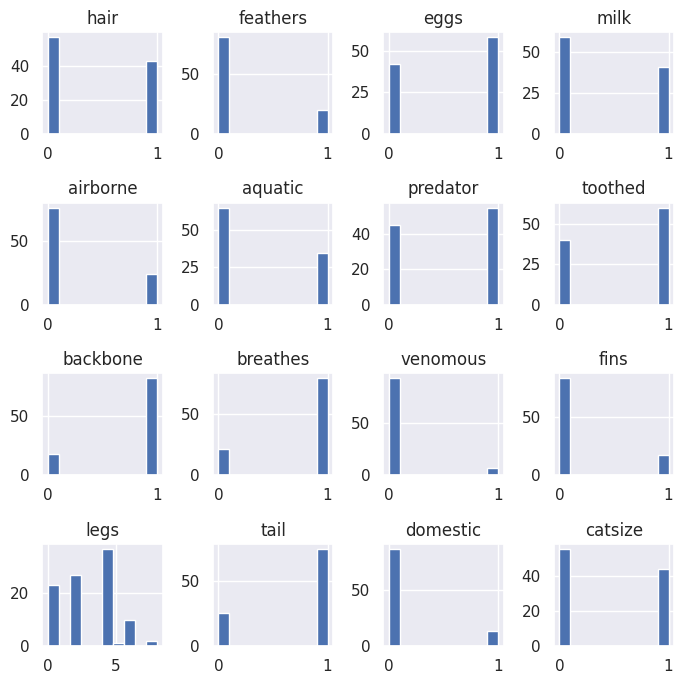

In [ ]:
_ = zoo_df.hist(figsize=(7,7))
plt.tight_layout()
# we can see the distribution of values in our categorical features
# majority of features is binary (except "legs")

### DBSCAN

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

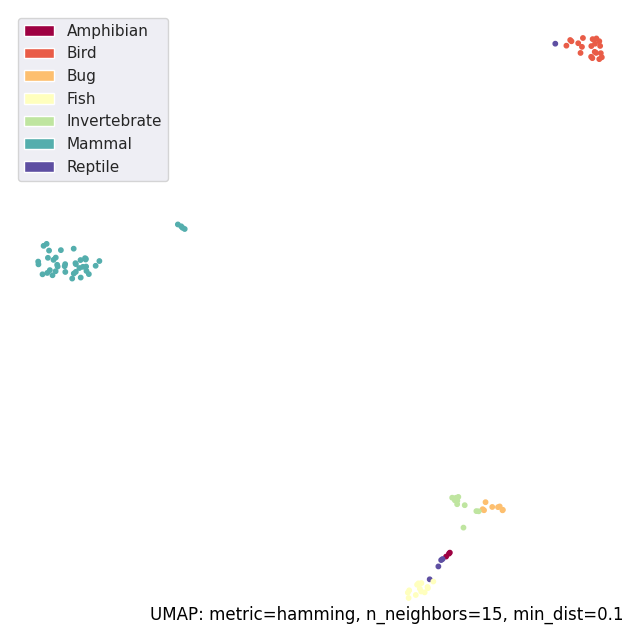

In [ ]:
# Default values
umap_obj = umap.UMAP(metric='hamming')
embedding = umap_obj.fit_transform(zoo_df.to_numpy())

uplot.points(umap_obj, labels=animal_class)
# we can use Umap in order to more or less distinguish between our animal classes

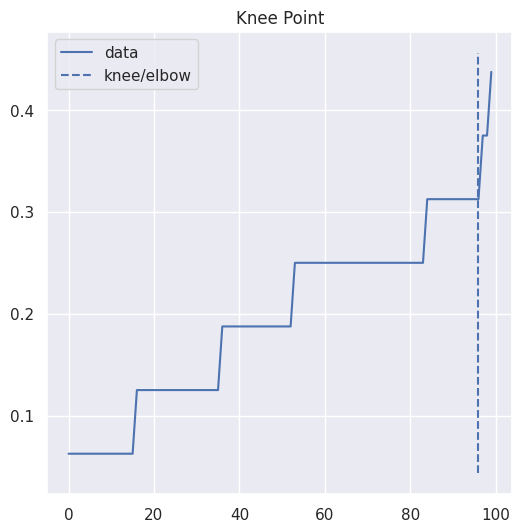

In [ ]:
# Identify MinPts
min_pts = zoo_df.shape[1] + 1

# Find distances to min_pts'th neighbor
knn = NearestNeighbors(metric='hamming')
knn.fit(zoo_df)
distances, _ = knn.kneighbors(zoo_df, n_neighbors=min_pts)

# Sort the distances to the min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]),
    sort_dist,
    S=1.0,
    curve="convex",
    direction="increasing"
)
kneedle.plot_knee()

<Axes: >

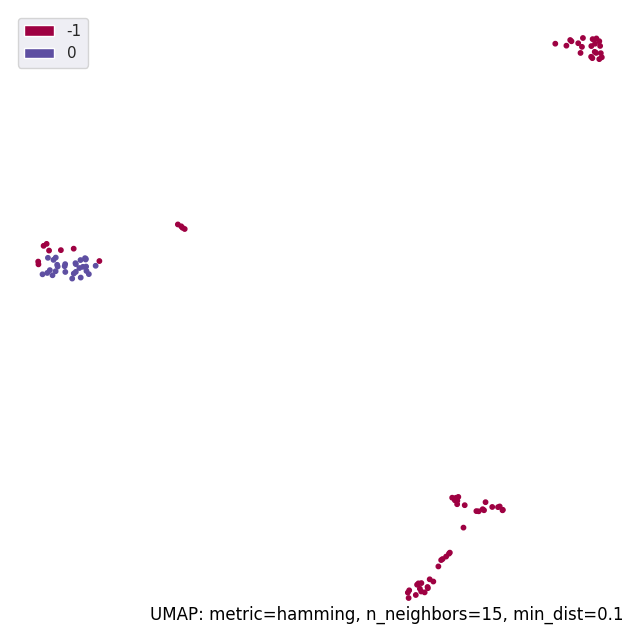

In [ ]:
# Cluster
dbscan = DBSCAN(eps=0.12, min_samples=min_pts, metric='hamming')
_ = dbscan.fit(zoo_df)

uplot.points(umap_obj, labels=dbscan.labels_)
# eps=0.31
# this clustering is no good because almost all all data points belong to a single cluster, with exception of a few outliers
# eps=0.12
# since we are having a hard time finding the real the optimal parameter combination, maybe we can also try different value for minimal number of points

In [ ]:
# Identify MinPts
min_pts = int(np.log(zoo_df.shape[0]))
min_pts

4

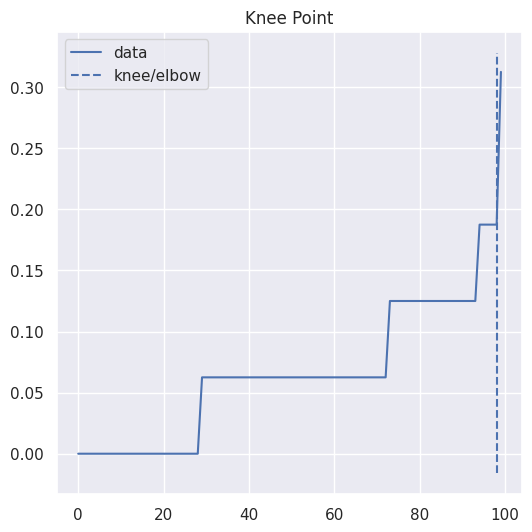

In [ ]:
# Find distances to min_pts'th neighbor
knn = NearestNeighbors(metric='hamming')
knn.fit(zoo_df)
distances, _ = knn.kneighbors(zoo_df, n_neighbors=min_pts)

# Sort the dsitances to min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]),
    sort_dist,
    S=1.0,
    curve="convex",
    direction="increasing"
)
kneedle.plot_knee()

<Axes: >

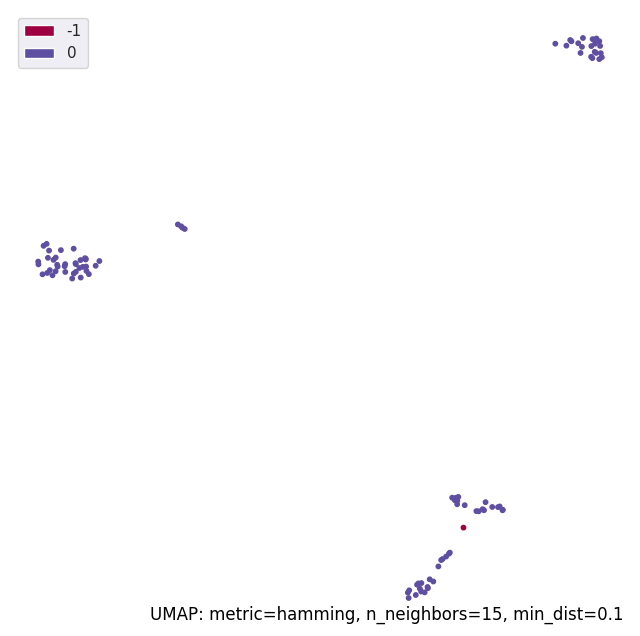

In [ ]:
dbscan = DBSCAN(eps=0.19, min_samples=min_pts, metric='hamming')
_ = dbscan.fit(zoo_df)

uplot.points(umap_obj, labels=dbscan.labels_)
# eps=0.19
# again we are out of luck, everything is a part of the same cluster

<Axes: >

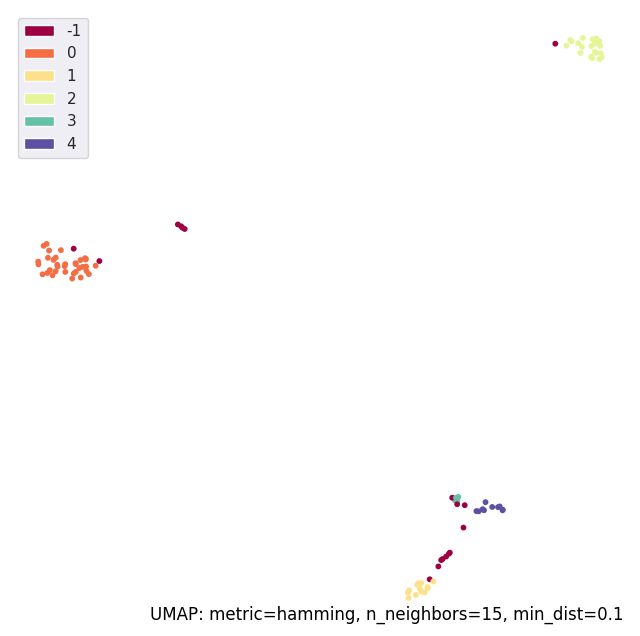

In [ ]:
dbscan = DBSCAN(eps=0.124, min_samples=min_pts, metric='hamming')
_ = dbscan.fit(zoo_df)

uplot.points(umap_obj, labels=dbscan.labels_)
# eps=0.124
# the clustering will actually be successful
# the DBscan manages to discover clusters in our data to some extent

In [ ]:
validity_index(
    X=zoo_df.to_numpy(),
    labels=dbscan.labels_,
    metric='hamming',
    per_cluster_scores=True
)
# we will get a score that is quite high

(0.6127542191897047,
 array([0.75068628, 0.79114531, 0.72442929, 0.74358365, 0.72535926]))

<Axes: >

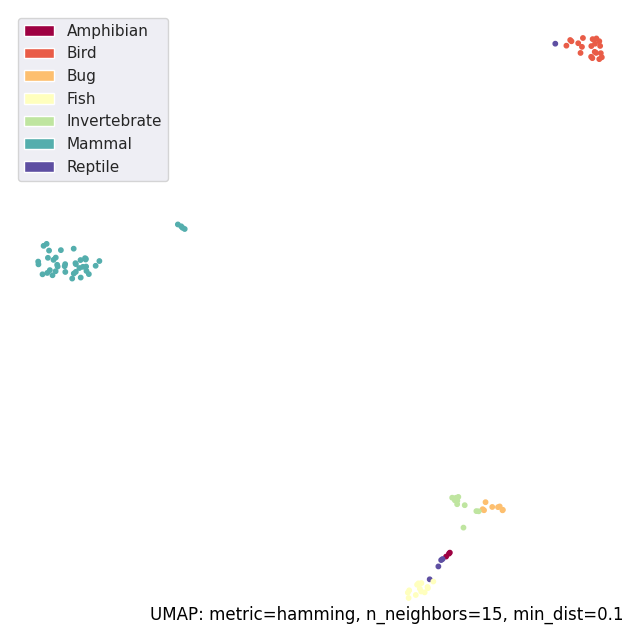

In [ ]:
uplot.points(umap_obj, labels=animal_class)
# if we compare this to the original clustering, you can see that DBscan manages to identify major groups

In [ ]:
adjusted_rand_score(animal_class, dbscan.labels_)
# and because of that, the adjusted rand score will be high
# despite obtaining the right results, you can see that we have that we had to put quite a lot of work into tuning
# DBscan parameters, which is troublesome in general case when it, when it comes to using DBscan

0.7826933472013362